# Process images ready for InstaGAN training

* This notebook takes input in the following format:

1) Cityscapes dataset

`cityscapes-dataset/gtFine_trainvaltest/gtFine/train/train/<city>/<mask>` - containing the fine grain masks of cities in Germany
`cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/<city>/<image>` - containing the correspondongimages of the city
    
1) Detroit video frames (target dataset)

`cityscapes/sampleB/<image>` - containing the frames from the video
`cityscapes/sampleB_seg/<mask>` - segmented masks for each of the buildings (generated from Mask_RCNN)
    
* It will process images in the following way:

Move into the correct folder structure for InstaGan (see below)
For the target dataset, remove any images where there is no identified buildings (and hence a blank mask)
Rename images to be of the format ```nnnn.jpg``` and `nnnn_m.jpg` (where n is 0-9 representing the image ID, m is 0-9 representing the mask ID)

* Output structure

Training data will be stored in the following directory structure:

`cityscapes/instagan/train/sampleA/<image>`
`cityscapes/instagan/train/sampleA_seg/<mask>`
`cityscapes/instagan/train/sampleB/<image>`
`cityscapes/instagan/train/sampleB_seg/<mask>`

Images that have no mask in the target dataset will be stored in:

`cityscapes/instagan/no_mask/sampleB/<image>`


In [17]:
import os
from pathlib import Path
import numpy as np
import json
import skimage

In [27]:
BASE_DIR = '../../datasets'
CITYSCAPES_DATASET_BASE = os.path.join(BASE_DIR, 'cityscapes-dataset')
CITYSCAPES_IMAGES = os.path.join(CITYSCAPES_DATASET_BASE, 'leftImg8bit_trainvaltest/leftImg8bit/train')
CITYSCAPES_MASKS = os.path.join(CITYSCAPES_DATASET_BASE, 'gtFine_trainvaltest/gtFine/train')

DERELICT_DATASET_BASE = os.path.join(BASE_DIR, 'cityscapes')
DERELICT_IMAGES = os.path.join(DERELICT_DATASET_BASE, 'sampleB')
DERELICT_MASKS = os.path.join(DERELICT_DATASET_BASE, 'sampleB_seg')

TRAIN_DATASET_BASE = os.path.join(BASE_DIR, 'aurora/instagan')
TRAIN_IMAGES_A = os.path.join(TRAIN_DATASET_BASE, 'train/sampleA')
TRAIN_MASKS_A = os.path.join(TRAIN_DATASET_BASE, 'train/sampleA_seg')
TRAIN_IMAGES_B = os.path.join(TRAIN_DATASET_BASE, 'train/sampleB')
TRAIN_MASKS_B = os.path.join(TRAIN_DATASET_BASE, 'train/sampleB_seg')

NO_MASK_A_DATASET = os.path.join(TRAIN_DATASET_BASE, 'no_mask/sampleA')
NO_MASK_B_DATASET = os.path.join(TRAIN_DATASET_BASE, 'no_mask/sampleB')


* Check target directories exist, if not create them

In [12]:
for directory in [TRAIN_IMAGES_A, TRAIN_MASKS_A, TRAIN_IMAGES_B, TRAIN_MASKS_B, NO_MASK_A_DATASET, NO_MASK_B_DATASET]:
    print('Checking directory {} exists...'.format(directory))
    if not Path(directory).is_dir():
        try:
            os.makedirs(directory)
        except OSError:
            print ("...Failed to create directory!!")
        else:
            print ('...Created OK!')

Checking directory ../../datasets/aurora/instagan/train/sampleA exists...
Checking directory ../../datasets/aurora/instagan/train/sampleA_seg exists...
Checking directory ../../datasets/aurora/instagan/train/sampleB exists...
Checking directory ../../datasets/aurora/instagan/train/sampleB_seg exists...
Checking directory ../../datasets/aurora/instagan/no_mask/sampleA exists...
Checking directory ../../datasets/aurora/instagan/no_mask/sampleB exists...


* Start with Cityscapes Dataset

Move from subdirectory per city to one image and one mask directory with files numbering 0000.jpg, etc

In [48]:
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()

def display_top_masks(image, mask, class_ids, class_names=['bg', 'building'], limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

In [49]:
def load_image(image_path):
    """Load the specified image and return a [H,W,3] Numpy array.
    """
    # Load image
    image = skimage.io.imread(image_path)
    # If grayscale. Convert to RGB for consistency.
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
    # If has an alpha channel, remove it for consistency
    if image.shape[-1] == 4:
        image = image[..., :3]
    return image
    
def load_masks(mask_dir, city, image_file):
    """
    Load mask for a specified image in the cityscapes dataset
    Code from Mask_RCNN/samples/cityscapes/cityscapes.py
    
    mask_dir: Top level directory containing cityscape masks (String)
    city: Name of city for this mask (String)
    image_file: Image name being processed (String)
    
    Returns np.array containing mask image
    """
    
    json_file = image_file.replace('_leftImg8bit.png', '_gtFine_polygons.json')
    json_filepath = os.path.join(mask_dir, city, json_file)

    # Load mask polygons json
    # From https://stackoverflow.com/a/55016816/1378071 as cityscapes json wouldn't load without this!
    with open(json_filepath, encoding='utf-8', errors='ignore') as json_data:
        mask_json = json.load(json_data, strict=False)

    h, w = mask_json['imgHeight'], mask_json['imgWidth']

    # Get masks for each object
    objects = list(mask_json['objects'])

    polygons = []
    for object in objects:
        obj_class = object['label']
        obj_polygons = object['polygon']
        if obj_class == 'building' and obj_polygons != []:
            polygon = dict()
            all_points_y, all_points_x = [], []
            for x, y in obj_polygons:
                # Handle polygons outside of image area
                x = x if x < w else w - 1
                y = y if y < h else h - 1
                all_points_x.append(x)
                all_points_y.append(y)
                polygon['all_points_y'] = all_points_y
                polygon['all_points_x'] = all_points_x
            polygons.append(polygon)
            
    mask = np.zeros((h, w, len(polygons)),
                        dtype=np.uint8)
    for i, p in enumerate(polygons):
        # Get indexes of pixels inside the polygon and set them to 1
        rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
        mask[rr, cc, i] = 1

    # Return mask, and array of class IDs of each instance. Since we have
    # one class ID only, we return an array of 1s
    return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000069_000019_leftImg8bit.png
Saving image as ../../datasets/aurora/instagan/train/sampleA/0.png


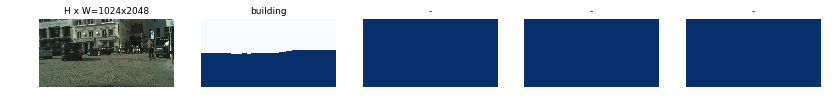

masks.shape=(1024, 2048, 1)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/0_0.png
Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000063_000019_leftImg8bit.png
Saving image as ../../datasets/aurora/instagan/train/sampleA/1.png


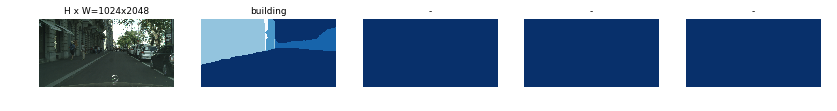

masks.shape=(1024, 2048, 3)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/1_0.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/1_1.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/1_2.png
Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000110_000019_leftImg8bit.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/1_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/1_1.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/1_2.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)


Saving image as ../../datasets/aurora/instagan/train/sampleA/2.png


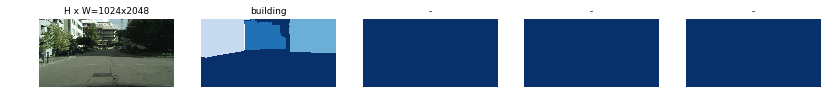

masks.shape=(1024, 2048, 3)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/2_0.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/2_1.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/2_2.png
Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000016_000019_leftImg8bit.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/2_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/2_1.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/2_2.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)


Saving image as ../../datasets/aurora/instagan/train/sampleA/3.png


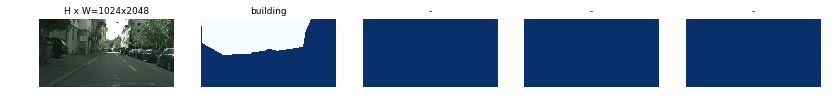

masks.shape=(1024, 2048, 1)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/3_0.png
Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000027_000019_leftImg8bit.png
Saving image as ../../datasets/aurora/instagan/train/sampleA/4.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/3_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)


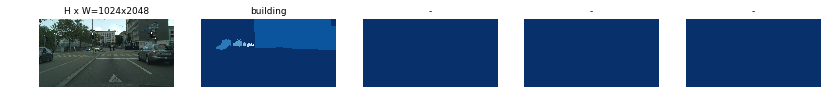

masks.shape=(1024, 2048, 7)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/4_0.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/4_1.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/4_2.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/4_3.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/4_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/4_1.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/4_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/4_2.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3

Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/4_4.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/4_5.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/4_6.png
Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000052_000019_leftImg8bit.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/4_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/4_4.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/4_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/4_5.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: ../..

Saving image as ../../datasets/aurora/instagan/train/sampleA/5.png


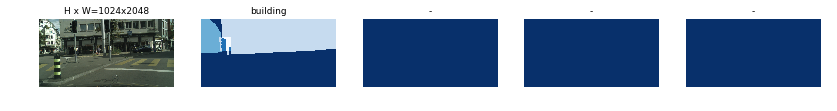

masks.shape=(1024, 2048, 3)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/5_0.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/5_1.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/5_2.png
Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000121_000019_leftImg8bit.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/5_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/5_1.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/5_2.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)


Saving image as ../../datasets/aurora/instagan/train/sampleA/6.png


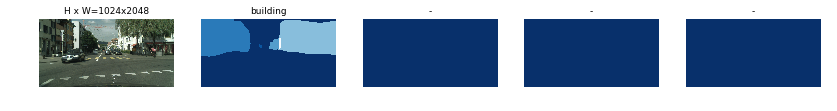

masks.shape=(1024, 2048, 4)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/6_0.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/6_1.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/6_2.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/6_3.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/6_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/6_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/6_1.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/6_2.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3

Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000093_000019_leftImg8bit.png
Saving image as ../../datasets/aurora/instagan/train/sampleA/7.png


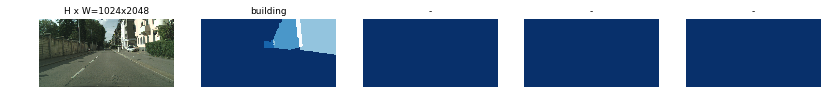

masks.shape=(1024, 2048, 3)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/7_0.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/7_1.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/7_2.png
Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000058_000019_leftImg8bit.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/7_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/7_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/7_1.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/7_2.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)


Saving image as ../../datasets/aurora/instagan/train/sampleA/8.png


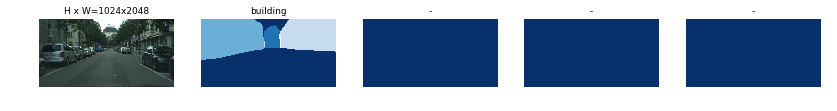

masks.shape=(1024, 2048, 3)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/8_0.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/8_1.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/8_2.png
Loading image ../../datasets/cityscapes-dataset/leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000099_000019_leftImg8bit.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/8_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/8_1.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/8_2.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)


Saving image as ../../datasets/aurora/instagan/train/sampleA/9.png


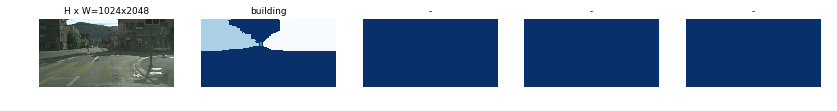

masks.shape=(1024, 2048, 3)
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/9_0.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/9_1.png
Saving mask as ../../datasets/aurora/instagan/train/sampleA_seg/9_2.png


/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/9_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/9_0.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/9_1.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)
/usr/local/lib/python3.7/site-packages/skimage/io/_io.py:142: UserWarning: ../../datasets/aurora/instagan/train/sampleA_seg/9_2.png is a boolean image: setting True to 1 and False to 0
  warn('%s is a boolean image: setting True to 1 and False to 0' % fname)


In [53]:
image_id = 0
image_list = Path(CITYSCAPES_IMAGES).glob('**/*.png')
for image_path in image_list:
    city, image_file = str(image_path).split(os.sep)[-2:]
    print('Processing image {}'.format(image_path))
    image = load_image(image_path)
    image_out_path = os.path.join(TRAIN_IMAGES_A, '{}.png'.format(image_id))
    # print('Saving image as {}'.format(image_out_path))
    skimage.io.imsave(image_out_path, image)
    masks, class_ids = load_masks(CITYSCAPES_MASKS, city, image_file)    # Ignore class IDs    
    # display_top_masks(image, masks, class_ids)    
    # print('masks.shape={}'.format(masks.shape))
    for mask_id in range(masks.shape[2]):
        mask = masks[:, :, mask_id]
        mask_out_path = os.path.join(TRAIN_MASKS_A, '{}_{}.png'.format(image_id, mask_id))
        # print('Saving mask as {}'.format(mask_out_path))
        skimage.io.imsave(mask_out_path, mask)  
    image_id += 1